In [ ]:
######################################################################
## 07_ANALYSIS: Differential Expression
######################################################################

### Note that any block starting with "SCRIPT" or "ON COMMAND LINE" should be run in terminal and not in notebook

In [1]:
######################################################################
## BLOCK 1: Environment & Helpers
######################################################################

suppressMessages({
  library(bsseq); library(DSS); library(GenomicRanges); library(GenomicFeatures)
  library(rtracklayer); library(tidyverse); library(pheatmap); library(cowplot)
  library(grid); library(gridExtra); library(ggplotify); library(scales); library(forcats)
  library(patchwork); library(bsseq); library(dplyr); library(tidyverse)
})

# ---- Parameters ----
FDR_LEVELS <- c(0.05, 0.10, 0.15)
FDR_SUFFIX <- function(x) sprintf("%02d", as.integer(100*x))  # 0.05 -> "05"
GFF_PATH   <- "~/Mytilus/genome/ncbi_dataset/data/GCF_021869535.1/genomic.gff"

# Colors
GROUP_COLORS <- c("Young"="#66C2A5","Intermediate"="#FC8D62","Old"="#8DA0CB")
ANNOT_COLORS <- list(AgeClass = GROUP_COLORS)

# Caching toggle: set to TRUE to force recompute even if cache exists
RECOMPUTE <- FALSE

# ---- Helpers ----
mc_labels <- function(x) { mid <- stringr::str_match(x, "-(\\d+)-")[,2]; ifelse(is.na(mid), x, paste0("MC", sprintf("%02d", as.integer(mid)))) }
fmt_q     <- function(x) ifelse(x < 1e-3, formatC(x, format="e", digits=2), sprintf("%.4f", x))
stars     <- function(q) case_when(q < 0.001 ~ "***", q < 0.01 ~ "**", q < 0.05 ~ "*", TRUE ~ "")
percent1  <- function(x) sprintf("%.1f%%", 100*x)

# Region labels for plots (note “Proximal Promoter”)
REGION_LEVELS_TC <- c("Proximal Promoter","Gene Body","Intergenic")
title_case_region <- function(x_chr){
  # map raw region codes -> title case with "Proximal Promoter"
  x_chr <- factor(x_chr, levels=c("promoter","gene_body","intergenic"))
  forcats::fct_recode(x_chr,
                      "Proximal Promoter"="promoter",
                      "Gene Body"="gene_body",
                      "Intergenic"="intergenic")
}

# Align seqlevels across objects to avoid warnings (and prune safely)
align_seqlevels2 <- function(a, b){
  common <- intersect(seqlevels(a), seqlevels(b))
  a2 <- keepSeqlevels(a, common, pruning.mode="coarse")
  b2 <- keepSeqlevels(b, common, pruning.mode="coarse")
  list(a2, b2)
}

# Quiet txdb maker (suppresses unavoidable transcript-id warnings)
make_txdb_quiet <- function(gff){
  suppressWarnings({
    if (requireNamespace("txdbmaker", quietly=TRUE)) txdbmaker::makeTxDbFromGFF(gff, format="gff3")
    else GenomicFeatures::makeTxDbFromGFF(gff, format="gff3")
  })
}

# Idempotent saver/loader for R objects
save_or_load <- function(path, maker){
  if (!file.exists(path) || RECOMPUTE) {
    obj <- maker()
    save(obj, file=path)
    obj
  } else {
    load(path, envir=environment())
    get(ls()[ls()!="path"][1], envir=environment())
  }
}

In [2]:
######################################################################
## BLOCK 2: Load BSseq object
######################################################################

load("bsseq_snp_masked.RData")   # sets bsseq_obj_snp_removed
BSobj <- BSseq_obj_masked


In [3]:
######################################################################
## BLOCK 3: Covariates / Design
######################################################################

covariates <- readr::read_csv("~/Jupyter_Mytilus/combined_covariates.csv", show_col_types = FALSE)
stopifnot(all(sampleNames(BSobj) %in% covariates$sample))

covariates <- covariates %>%
  filter(sample %in% sampleNames(BSobj)) %>%
  arrange(factor(sample, levels = sampleNames(BSobj)))

design <- covariates %>% column_to_rownames("sample")
design$group <- factor(design$group, levels = c("Young","Intermediate","Old"))

In [ ]:
######################################################################
## BLOCK 4: Fit DSS Multi-Factor Model (cache-aware; load-or-compute)
######################################################################

suppressMessages(library(DSS))

# ---- Preconditions ----
stopifnot(exists("BSobj"), exists("design"), "group" %in% colnames(design))
# Ensure factor order: Young (baseline), then Intermediate, Old
design$group <- factor(design$group, levels = c("Young", "Intermediate", "Old"))

# ---- Output files ----
fit_rds    <- "dml_fit_group_only.rds"
test_i_rds <- "dml_test_intermediate.rds"  # Intermediate vs Young
test_o_rds <- "dml_test_old.rds"           # Old vs Young

# ---- Toggle (set TRUE only if you truly want to refit) ----
RECOMPUTE_DSS <- FALSE

# ---- Helpers ----
safe_readRDS <- function(path) tryCatch(readRDS(path), error = function(e) NULL)
have_all     <- function(...) all(file.exists(c(...)))

# ---- Load-or-compute logic ----
if (!RECOMPUTE_DSS && have_all(fit_rds, test_i_rds, test_o_rds)) {
  message("[DSS] Loading existing fit/tests …")
  dml_fit_group_only    <- safe_readRDS(fit_rds)
  dml_test_intermediate <- safe_readRDS(test_i_rds)
  dml_test_old          <- safe_readRDS(test_o_rds)
  if (is.null(dml_fit_group_only) || is.null(dml_test_intermediate) || is.null(dml_test_old)) {
    message("[DSS] One or more cached files are unreadable; refitting …")
    RECOMPUTE_DSS <- TRUE
  }
}

if (isTRUE(RECOMPUTE_DSS) || !have_all(fit_rds, test_i_rds, test_o_rds)) {
  message("[DSS] Fitting multi-factor model: ~ group")
  t0 <- Sys.time()

  dml_fit_group_only <- DSS::DMLfit.multiFactor(
    BSobj   = BSobj,
    design  = design,
    formula = ~ group
  )
  saveRDS(dml_fit_group_only, fit_rds)

  message("[DSS] Testing contrast: groupIntermediate (Intermediate vs Young)")
  dml_test_intermediate <- DSS::DMLtest.multiFactor(dml_fit_group_only, coef = "groupIntermediate")
  saveRDS(dml_test_intermediate, test_i_rds)

  message("[DSS] Testing contrast: groupOld (Old vs Young)")
  dml_test_old <- DSS::DMLtest.multiFactor(dml_fit_group_only, coef = "groupOld")
  saveRDS(dml_test_old, test_o_rds)

  message(sprintf(
    "[DSS] Done in %.1f min. Files: %s | %s | %s",
    as.numeric(difftime(Sys.time(), t0, units = "mins")),
    normalizePath(fit_rds, mustWork = FALSE),
    normalizePath(test_i_rds, mustWork = FALSE),
    normalizePath(test_o_rds, mustWork = FALSE)
  ))
} else {
  message("[DSS] Using cached results. Files are up to date: ",
          paste(c(fit_rds, test_i_rds, test_o_rds), collapse = " | "))
}

# ---- Sanity summaries (quick, optional) ----
summarise_dml <- function(obj, label) {
  df <- as.data.frame(obj); n_all <- nrow(df); n_nonNA <- sum(!is.na(df$fdrs))
  message(sprintf("[DSS] %s: rows=%s, with FDRs=%s",
                  label, format(n_all, big.mark=","), format(n_nonNA, big.mark=",")))
  invisible(df)
}
invisible(summarise_dml(dml_test_intermediate, "Intermediate vs Young"))
invisible(summarise_dml(dml_test_old,          "Old vs Young"))

In [ ]:
######################################################################
## BLOCK 5: Identify DMLs & DMRs (idempotent; ≤FDR)
######################################################################

summary_table <- list()
for (fdr in FDR_LEVELS) {
  sfx <- FDR_SUFFIX(fdr)

  dmls_intermediate <- as.data.frame(dml_test_intermediate) %>%
    filter(!is.na(fdrs), fdrs <= fdr) %>%
    mutate(direction = if_else(stat > 0, "hyper", "hypo"),
           contrast  = "Intermediate_vs_Young")
  dmls_old <- as.data.frame(dml_test_old) %>%
    filter(!is.na(fdrs), fdrs <= fdr) %>%
    mutate(direction = if_else(stat > 0, "hyper", "hypo"),
           contrast  = "Old_vs_Young")

  write_csv(dmls_intermediate, paste0("DMLs_groupIntermediate_vs_Young_", sfx, ".csv"))
  write_csv(dmls_old,          paste0("DMLs_groupOld_vs_Young_",          sfx, ".csv"))

  # UNION at this FDR
  dml_union <- bind_rows(dmls_intermediate, dmls_old) %>%
    arrange(chr, pos) %>%
    distinct(chr, pos, .keep_all = TRUE)

  write_csv(dml_union, paste0("DMLs_union_fdr", sfx, ".csv"))

  summary_table[[sfx]] <- tibble(
    set        = c("Intermediate vs Young", "Old vs Young", "UNION"),
    fdr_cutoff = fdr,
    DMLs       = c(nrow(dmls_intermediate), nrow(dmls_old), nrow(dml_union))
  )
}

bind_rows(summary_table) %>% write_csv("DML_counts_by_threshold.csv")

# DMRs (use same settings as before; compute fresh each run)
p_cutoff <- 0.001
dmrs_old  <- callDMR(dml_test_old,          p.threshold = p_cutoff, minCG = 3, dis.merge = 100, minlen = 50, pct.sig = 0.5)
dmrs_int  <- callDMR(dml_test_intermediate, p.threshold = p_cutoff, minCG = 3, dis.merge = 100, minlen = 50, pct.sig = 0.5)
write_csv(as.data.frame(dmrs_old), "DMRs_groupOld_vs_Young.csv")
write_csv(as.data.frame(dmrs_int), "DMRs_groupIntermediate_vs_Young.csv")

In [ ]:
######################################################################
## BLOCK 6: Extract Methylation Matrices (UNION & contrasts)
######################################################################

suppressMessages({ library(readr); library(tidyr); library(tibble) })

# If you ran Block 4 in the same session, these are already in memory.
# If not, uncomment these two lines:
dml_test_intermediate <- readRDS("dml_test_intermediate.rds")
dml_test_old          <- readRDS("dml_test_old.rds")

# Helper: filter DSS table at FDR and keep key columns
filter_dml <- function(dml_test_obj, fdr_cutoff) {
  as.data.frame(dml_test_obj) %>%
    # DSS uses column 'fdrs' (lower is better)
    dplyr::filter(!is.na(fdrs), fdrs <= fdr_cutoff) %>%
    # keep common/useful columns if present
    dplyr::select(dplyr::any_of(c(
      "chr","pos","stat","mu1","mu2","diff","pvals","fdrs"
    )))
}

fdr_cutoffs <- c(0.05, 0.10, 0.15)
suffixes    <- c("05",  "10",  "15")

summary_table <- list()

for (i in seq_along(fdr_cutoffs)) {
  fdr_cutoff <- fdr_cutoffs[i]
  suffix     <- suffixes[i]

  # Per-contrast DMLs
  dmls_intermediate <- filter_dml(dml_test_intermediate, fdr_cutoff)
  dmls_old          <- filter_dml(dml_test_old,          fdr_cutoff)

  # Write per-contrast CSVs
  write_csv(dmls_intermediate, paste0("DMLs_groupIntermediate_vs_Young_", suffix, ".csv"))
  write_csv(dmls_old,          paste0("DMLs_groupOld_vs_Young_",          suffix, ".csv"))

  # UNION across both contrasts (distinct by chr+pos)
  dmls_union <- dplyr::bind_rows(
      dmls_intermediate %>% mutate(source = "Intermediate_vs_Young"),
      dmls_old          %>% mutate(source = "Old_vs_Young")
    ) %>%
    arrange(chr, pos, fdrs) %>%
    distinct(chr, pos, .keep_all = TRUE)

  write_csv(dmls_union, paste0("DMLs_union_fdr", suffix, ".csv"))

  message(sprintf("✅ FDR %.2f — Intermediate vs Young: %d; Old vs Young: %d; UNION: %d",
                  fdr_cutoff, nrow(dmls_intermediate), nrow(dmls_old), nrow(dmls_union)))

  summary_table[[suffix]] <- tibble(
    fdr_cutoff = fdr_cutoff,
    comparison = c("Intermediate vs Young", "Old vs Young", "UNION (either)"),
    DMLs       = c(nrow(dmls_intermediate), nrow(dmls_old), nrow(dmls_union))
  )
}

bind_rows(summary_table) %>%
  write_csv("DML_counts_by_threshold.csv")

In [ ]:
######################################################################
## BLOCK 7A: Build/Cache TxDb, promoters & gene bodies; annotate UNION DMLs;
##           (optionally) background CpGs + enrichment (cache-aware)
######################################################################

suppressMessages({
  library(GenomeInfoDb)
  library(S4Vectors)
  library(IRanges)
  library(glue)
  library(readr)
  library(dplyr)
  library(tidyr)
  library(tibble)
  library(GenomicFeatures)
  library(forcats)
  library(purrr)
})

# ---------------- Parameters ----------------
FDR_TO_ANNOTATE   <- 0.05
PROMOTER_UPSTREAM <- 2000     # 150 / 1000 / 2000
QUICK_ONLY_UNION  <- FALSE    # TRUE = skip background/enrichment entirely (fast)
METH_MEAN_THRESHOLD <- 0.5    # mean beta threshold to call a CpG "methylated"
sfx <- sprintf("%02d", as.integer(100 * FDR_TO_ANNOTATE))

# ---------------- Inputs ----------------
stopifnot(exists("BSobj"), exists("GFF_PATH"))
union_csv <- paste0("DMLs_union_fdr", sfx, ".csv")
stopifnot(file.exists(union_csv))

# ---------------- Cache paths ----------------
cache_txdb   <- "cache_txdb.rds"
cache_gb     <- "cache_gene_body_gr.rds"
cache_prom   <- glue("cache_promoters_up{PROMOTER_UPSTREAM}.rds")
cache_bg_reg <- glue("cache_all_sites_regions_up{PROMOTER_UPSTREAM}.rds")  # vector of region labels

# ---------------- Load-or-build TxDb / promoters / gene bodies ---------------
if (!exists("txdb") || is.null(txdb)) {
  if (file.exists(cache_txdb)) {
    message("[7] Loading cached TxDb …"); txdb <- readRDS(cache_txdb)
  } else {
    message("[7] Building TxDb from GFF …")
    if (requireNamespace("txdbmaker", quietly = TRUE)) {
      txdb <- txdbmaker::makeTxDbFromGFF(GFF_PATH, format = "gff3")
    } else {
      txdb <- GenomicFeatures::makeTxDbFromGFF(GFF_PATH, format = "gff3")
    }
    saveRDS(txdb, cache_txdb); message("[7] Cached TxDb -> ", cache_txdb)
  }
}
if (!exists("gene_body_gr") || is.null(gene_body_gr)) {
  if (file.exists(cache_gb)) {
    message("[7] Loading cached gene_body GRanges …"); gene_body_gr <- readRDS(cache_gb)
  } else {
    message("[7] Building gene_body GRanges …")
    exons_gr   <- exons(txdb)
    introns_gr <- intronsByTranscript(txdb) %>% unlist(use.names = FALSE)
    gene_body_gr <- GenomicRanges::reduce(c(exons_gr, introns_gr))
    saveRDS(gene_body_gr, cache_gb); message("[7] Cached gene_body -> ", cache_gb)
  }
}
if (!exists("prom_gr") || is.null(prom_gr)) {
  if (file.exists(cache_prom)) {
    message("[7] Loading cached promoters (upstream=", PROMOTER_UPSTREAM, ") …")
    prom_gr <- readRDS(cache_prom)
  } else {
    message("[7] Building promoters (upstream=", PROMOTER_UPSTREAM, ") …")
    prom_gr <- promoters(txdb, upstream = PROMOTER_UPSTREAM, downstream = 0)
    saveRDS(prom_gr, cache_prom); message("[7] Cached promoters -> ", cache_prom)
  }
}

# ---------------- Helpers (alignment & region annotation) ---------------------
align_seqlevels2 <- function(x, y) {
  common <- intersect(seqlevels(x), seqlevels(y))
  if (length(common) == 0L) return(list(x = x[0], y = y[0]))
  x2 <- keepSeqlevels(x, common, pruning.mode = "coarse")
  y2 <- keepSeqlevels(y, common, pruning.mode = "coarse")
  seqinfo(x2) <- seqinfo(y2)[seqlevels(x2)]
  list(x = x2, y = y2)
}
annotate_points_by_region <- function(gr_points, prom_gr, gene_body_gr) {
  out <- rep("intergenic", length(gr_points))
  if (!length(gr_points)) return(factor(out, levels = c("promoter","gene_body","intergenic")))
  mcols(gr_points)$orig_ix <- seq_along(gr_points)
  a1 <- align_seqlevels2(gr_points, gene_body_gr)
  if (length(a1$x) && length(a1$y)) {
    hits_gb <- findOverlaps(a1$x, a1$y, ignore.strand = TRUE)
    if (length(hits_gb)) out[mcols(a1$x)$orig_ix[queryHits(hits_gb)]] <- "gene_body"
  }
  a2 <- align_seqlevels2(gr_points, prom_gr)
  if (length(a2$x) && length(a2$y)) {
    hits_pr <- findOverlaps(a2$x, a2$y, ignore.strand = TRUE)
    if (length(hits_pr)) out[mcols(a2$x)$orig_ix[queryHits(hits_pr)]] <- "promoter"
  }
  factor(out, levels = c("promoter","gene_body","intergenic"))
}

# ---------------- UNION DMLs: annotate once + standardize labels --------------
union_df <- readr::read_csv(union_csv, show_col_types = FALSE)
stopifnot(all(c("chr","pos") %in% names(union_df)))
dml_gr <- GRanges(seqnames = union_df$chr, ranges = IRanges(union_df$pos, union_df$pos), strand = "*")

message("[7] Annotating UNION DMLs …")
dml_reg <- annotate_points_by_region(dml_gr, prom_gr, gene_body_gr)
stopifnot(length(dml_reg) == nrow(union_df))
union_annot <- union_df %>% mutate(region = as.character(dml_reg))

# ---- Standardize display label for promoter everywhere ----
REGION_LEVELS_RAW <- c("promoter","gene_body","intergenic")
REGION_LEVELS_TC  <- c("Gene Body","Intergenic","5' Regulatory Region")
title_case_region <- function(x_chr){
  f <- forcats::fct_recode(
    factor(x_chr, levels = REGION_LEVELS_RAW),
    "5' Regulatory Region" = "promoter",
    "Gene Body"            = "gene_body",
    "Intergenic"           = "intergenic"
  )
  forcats::fct_relevel(f, REGION_LEVELS_TC)
}
union_annot <- union_annot %>% mutate(region = title_case_region(region))

out_annot <- paste0("DMLs_union_fdr", sfx, "_annotated.csv")
readr::write_csv(union_annot, out_annot)
message("[7] Wrote annotated DMLs -> ", out_annot)

# ---------------- Optional: background CpGs + enrichment -----------------------
if (!QUICK_ONLY_UNION) {
  # Build background counts from cached labels if available (no BSobj materialization)
  if (file.exists(cache_bg_reg)) {
    message("[7] Loading cached background region labels (vector only) …")
    bg_region <- readRDS(cache_bg_reg)               # raw keys
  } else {
    message("[7] Annotating background CpGs (first-time heavy step) …")
    all_sites_gr <- granges(BSobj)
    bg_region <- annotate_points_by_region(all_sites_gr, prom_gr, gene_body_gr)
    bg_region <- as.character(bg_region)
    saveRDS(bg_region, cache_bg_reg)
    # optional: keep GRanges w/ labels in memory
    mcols(all_sites_gr)$region <- bg_region
    assign("all_sites_gr", all_sites_gr, envir = .GlobalEnv)
  }

  # Counts for ALL CpGs by display labels
  bg_tc     <- title_case_region(bg_region)
  bg_counts <- table(bg_tc)

  # Counts for METHYLATED CpGs by display labels (mean beta across samples ≥ threshold)
  meth_mat   <- bsseq::getMeth(BSobj, type = "raw")  # rows: loci
  meth_mean  <- rowMeans(meth_mat, na.rm = TRUE)
  is_methylated <- meth_mean >= METH_MEAN_THRESHOLD
  bg_counts_methylated <- table(bg_tc[is_methylated])

  # Persist both for Panel A
  readr::write_csv(
    tibble(
      region             = names(bg_counts),
      count_all_cpgs     = as.integer(bg_counts),
      count_methylated   = as.integer(bg_counts_methylated[names(bg_counts)]),
      promoter_upstream  = PROMOTER_UPSTREAM,
      meth_threshold     = METH_MEAN_THRESHOLD
    ),
    glue::glue("bg_counts_and_methylated_up{PROMOTER_UPSTREAM}.csv")
  )

  # Enrichment of DMLs vs ALL CpGs (as before)
  REGION_LEVELS_TC <- c("Gene Body","Intergenic","5' Regulatory Region")
  enrich_tbl <- purrr::map_dfr(REGION_LEVELS_TC, function(reg) {
    dml_in  <- sum(union_annot$region == reg, na.rm = TRUE)
    dml_out <- nrow(union_annot) - dml_in
    bg_in   <- as.integer(bg_counts[reg])
    bg_out  <- sum(bg_counts) - bg_in
    ft <- fisher.test(matrix(c(dml_in, dml_out, bg_in, bg_out), nrow = 2))
    tibble(region = reg,
           odds_ratio = unname(ft$estimate),
           lo = unname(ft$conf.int[1]),
           hi = unname(ft$conf.int[2]),
           p_value = ft$p.value,
           fdr = FDR_TO_ANNOTATE)
  }) %>% mutate(p_adj = p.adjust(p_value, method = "BH"))

  readr::write_csv(enrich_tbl, "DML_region_enrichment_results.csv")
  message("[7] Wrote enrichment stats -> DML_region_enrichment_results.csv")
}

# ---------------- Hand-off objects for later blocks ----------------------------
assign("txdb",         txdb,         envir = .GlobalEnv)
assign("prom_gr",      prom_gr,      envir = .GlobalEnv)
assign("gene_body_gr", gene_body_gr, envir = .GlobalEnv)
message("[7] Done.")

In [ ]:
######################################################################
## BLOCK 7B: Robust TxDb loader 
######################################################################

suppressMessages({
  library(AnnotationDbi)
})

get_txdb_sqlite <- function(gff_path, sqlite_path = "cache_txdb.sqlite") {
  build_txdb <- function() {
    if (requireNamespace("txdbmaker", quietly = TRUE)) {
      tx <- txdbmaker::makeTxDbFromGFF(gff_path, format = "gff3")
    } else {
      tx <- GenomicFeatures::makeTxDbFromGFF(gff_path, format = "gff3")
    }
    AnnotationDbi::saveDb(tx, sqlite_path)
    tx
  }

  tx <- NULL
  if (file.exists(sqlite_path)) {
    tx <- AnnotationDbi::loadDb(sqlite_path)
    ok <- tryCatch({
      suppressWarnings(length(GenomicFeatures::genes(tx)))  # sanity test
      TRUE
    }, error = function(e) FALSE)
    if (!ok) {
      message("[TxDb] Cached SQLite looks stale; rebuilding from GFF …")
      try(unlink(sqlite_path, force = TRUE), silent = TRUE)
      tx <- build_txdb()
    }
  } else {
    message("[TxDb] No SQLite cache; building from GFF …")
    tx <- build_txdb()
  }
  tx
}

## Use it:
stopifnot(exists("GFF_PATH"))
txdb <- get_txdb_sqlite(GFF_PATH)

In [ ]:
######################################################################
## BLOCK 8: Increasing/Decreasing locus & gene sets (UNION)
######################################################################

suppressMessages({
  library(tidyverse)
  library(GenomicFeatures)   # use explicit namespace to avoid topGO::genes
  library(GenomicRanges)
  library(IRanges)
  library(S4Vectors)
})

# ---- Inputs from prior blocks ----
FDR_TO_ANNOTATE <- 0.05
sfx        <- sprintf("%02d", as.integer(100*FDR_TO_ANNOTATE))
PROM_UP    <- if (exists("PROMOTER_UPSTREAM")) PROMOTER_UPSTREAM else 2000
union_csv  <- paste0("DMLs_union_fdr", sfx, "_annotated.csv")  # from Block 7
stopifnot(file.exists(union_csv))
stopifnot(exists("txdb"))        # built in Block 7

# ---- Small helpers (length-stable) ----
align_seqlevels2 <- function(x, y) {
  common <- intersect(seqlevels(x), seqlevels(y))
  if (length(common) == 0L) {
    return(list(x = x[0], y = y[0]))
  }
  x2 <- keepSeqlevels(x, common, pruning.mode = "coarse")
  y2 <- keepSeqlevels(y, common, pruning.mode = "coarse")
  seqinfo(x2) <- seqinfo(y2)[seqlevels(x2)]
  list(x = x2, y = y2)
}

# ---- Load UNION (must contain chr/pos; region column is OK but not required) ----
union_df <- readr::read_csv(union_csv, show_col_types = FALSE)
stopifnot(all(c("chr","pos") %in% names(union_df)))
dml_gr <- GRanges(seqnames = union_df$chr,
                  ranges   = IRanges(union_df$pos, union_df$pos),
                  strand   = "*")
mcols(dml_gr)$orig_ix <- seq_along(dml_gr)

# ---- Build gene-level objects (use GenomicFeatures::genes to dodge topGO) ----
genes_gr <- GenomicFeatures::genes(txdb)           # one range per gene; names() are gene IDs
if (is.null(names(genes_gr))) {
  # some TxDb builds carry gene_id in a column instead of names()
  if ("gene_id" %in% colnames(mcols(genes_gr))) {
    names(genes_gr) <- as.character(mcols(genes_gr)$gene_id)
  }
}

# promoters defined at gene TSS (1 per gene)
prom_genes <- promoters(genes_gr, upstream = PROM_UP, downstream = 0)
mcols(prom_genes)$gene_id <- names(genes_gr)
mcols(genes_gr)$gene_id   <- names(genes_gr)

# ---- Map DMLs to promoters (first) ----
prom_aln <- align_seqlevels2(dml_gr, prom_genes)
gene_id_vec <- rep(NA_character_, length(dml_gr))
if (length(prom_aln$x) && length(prom_aln$y)) {
  hp <- findOverlaps(prom_aln$x, prom_aln$y, ignore.strand = TRUE)
  if (length(hp)) {
    gene_id_vec[mcols(prom_aln$x)$orig_ix[queryHits(hp)]] <-
      mcols(prom_aln$y)$gene_id[subjectHits(hp)]
  }
}

# ---- Fill remaining via gene bodies (gene spans) ----
need <- which(is.na(gene_id_vec))
if (length(need)) {
  gb_aln <- align_seqlevels2(dml_gr[need], genes_gr)
  if (length(gb_aln$x) && length(gb_aln$y)) {
    hg <- findOverlaps(gb_aln$x, gb_aln$y, ignore.strand = TRUE)
    if (length(hg)) {
      gene_id_vec[ mcols(gb_aln$x)$orig_ix[queryHits(hg)] ] <-
        mcols(gb_aln$y)$gene_id[subjectHits(hg)]
    }
  }
}

# ---- (Optional) nearest gene for remaining intergenic sites (comment to skip) ----
# If you want every DML tagged to the closest gene (not just promoter/gene body), uncomment.
# still_need <- which(is.na(gene_id_vec))
# if (length(still_need)) {
#   ng_aln <- align_seqlevels2(dml_gr[still_need], genes_gr)
#   if (length(ng_aln$x) && length(ng_aln$y)) {
#     nn <- nearest(ng_aln$x, ng_aln$y, ignore.strand = TRUE)
#     ok <- which(!is.na(nn))
#     if (length(ok)) {
#       gene_id_vec[ mcols(ng_aln$x)$orig_ix[ok] ] <- mcols(ng_aln$y)$gene_id[nn[ok]]
#     }
#   }
# }

# ---- Write back into a length-stable data frame and save ----
stopifnot(length(gene_id_vec) == nrow(union_df))
union_with_gene <- union_df %>% mutate(gene_id = gene_id_vec)

out_csv <- paste0("DMLs_union_fdr", sfx, "_annotated_with_gene.csv")
readr::write_csv(union_with_gene, out_csv)

message(sprintf(
  "[8] DML→gene mapping complete (promoter ±%d first, then gene span):\n  mapped %d / %d (%.1f%%)\n  wrote: %s",
  PROM_UP, sum(!is.na(gene_id_vec)), length(gene_id_vec),
  100*mean(!is.na(gene_id_vec)), out_csv
))

# ---- Handy outputs for downstream blocks (INC/DEC gene sets, if trend_df exists) ----
if (exists("trend_df")) {
  union_trended <- union_with_gene %>%
    mutate(locus = paste0(chr, ":", pos)) %>%
    left_join(trend_df, by = "locus")

  inc_genes <- union_trended %>% filter(trend == "Increasing") %>%
    pull(gene_id) %>% na.omit() %>% unique() %>% sort()
  dec_genes <- union_trended %>% filter(trend == "Decreasing") %>%
    pull(gene_id) %>% na.omit() %>% unique() %>% sort()

  readr::write_lines(inc_genes, paste0("UNION_fdr", sfx, "_INC_genes.txt"))
  readr::write_lines(dec_genes, paste0("UNION_fdr", sfx, "_DEC_genes.txt"))
  message(sprintf("[8] Wrote gene lists: INC=%d, DEC=%d", length(inc_genes), length(dec_genes)))
}

In [4]:
######################################################################
## PRE-BLOCK 9: Fast loader for a fresh session
## Loads design, union_annot, and background counts from disk (if needed)
######################################################################

suppressMessages({
  library(readr); library(dplyr); library(tidyr); library(tibble); library(glue); library(forcats)
})

## --- Params (only set defaults if missing in session) ---
if (!exists("FDR_TO_ANNOTATE"))     FDR_TO_ANNOTATE <- 0.05
if (!exists("PROMOTER_UPSTREAM"))   PROMOTER_UPSTREAM <- 2000
sfx <- sprintf("%02d", as.integer(100 * FDR_TO_ANNOTATE))

## --- Helpers (match 7A/9 conventions) ---
REGION_LEVELS_TC <- c("Gene Body","Intergenic","5' Regulatory Region")
enforce_region_order <- function(x) factor(as.character(x), levels = REGION_LEVELS_TC)

## --- design: prefer in-memory; else try RDS then CSV ---
if (!exists("design")) {
  if (file.exists("design.rds")) {
    message("[PRE9] Loading design.rds …")
    design <- readRDS("design.rds")
  } else if (file.exists("design.csv")) {
    message("[PRE9] Loading design.csv …")
    design <- readr::read_csv("design.csv", show_col_types = FALSE)
    if (!is.null(design$sample_id)) rownames(design) <- design$sample_id
  } else {
    stop("[PRE9] No design in memory and no design.rds / design.csv on disk.")
  }
}
stopifnot("group" %in% colnames(design))

## --- union_annot: prefer in-memory; else load CSV written by 7A ---
if (!exists("union_annot")) {
  ua_csv <- glue("DMLs_union_fdr{sfx}_annotated.csv")
  if (file.exists(ua_csv)) {
    message("[PRE9] Loading ", ua_csv, " …")
    union_annot <- readr::read_csv(ua_csv, show_col_types = FALSE)
  } else {
    stop("[PRE9] union_annot not in memory and ", ua_csv, " not found. Re-run Block 7A.")
  }
}
## normalize & order region labels just in case
if ("region" %in% names(union_annot)) {
  # allow either raw or display labels; coerce to display set
  union_annot <- union_annot %>%
    mutate(region = case_when(
      region %in% REGION_LEVELS_TC        ~ region,
      region == "promoter"                ~ "5' Regulatory Region",
      region == "gene_body"               ~ "Gene Body",
      region == "intergenic"              ~ "Intergenic",
      TRUE                                ~ as.character(region)
    )) %>%
    mutate(region = enforce_region_order(region))
} else {
  stop("[PRE9] union_annot lacks a 'region' column.")
}
stopifnot(all(c("chr","pos") %in% names(union_annot)))

## --- background counts CSV (written by 7A) ---
bg_counts_csv <- glue("bg_counts_and_methylated_up{PROMOTER_UPSTREAM}.csv")
if (!file.exists(bg_counts_csv)) {
  message("[PRE9] NOTE: ", bg_counts_csv, " is missing. Block 9 can still run, ",
          "but Panel A will compute methylated counts on the fly (requires {bsseq}).")
} else {
  message("[PRE9] Found background counts: ", bg_counts_csv)
}

## --- meth matrix RDS (written by Block 6/7) ---
meth_mat_rds <- glue("meth_matrix_dml_union_fdr{sfx}.rds")
if (!file.exists(meth_mat_rds)) {
  stop("[PRE9] Missing ", meth_mat_rds, ". Re-run Block 6 (matrix build) before Block 9.")
} else {
  message("[PRE9] Found methylation matrix: ", meth_mat_rds)
}

message("[PRE9] Ready. You can run Block 9 now.")

[PRE9] Loading DMLs_union_fdr05_annotated.csv …

[PRE9] Found background counts: bg_counts_and_methylated_up2000.csv

[PRE9] Found methylation matrix: meth_matrix_dml_union_fdr05.rds

[PRE9] Ready. You can run Block 9 now.



In [146]:
# ===== BLOCK 9: FIGURE PREP =====

suppressMessages({
  library(glue); library(dplyr); library(tidyr); library(tibble); library(purrr)
  library(readr); library(forcats); library(ggplot2); library(scales)
  library(pheatmap); library(cowplot); library(gridExtra); library(ggplotify); library(grid)
})

stopifnot(exists("design"), exists("union_annot"), exists("PROMOTER_UPSTREAM"), exists("FDR_TO_ANNOTATE"))
sfx <- sprintf("%02d", as.integer(100 * FDR_TO_ANNOTATE))

REGION_LEVELS_TC <- c("Gene Body","Intergenic","5' Regulatory Region")
enforce_region_order <- function(x) factor(as.character(x), levels = REGION_LEVELS_TC)

# Colors (match older figure)
COL_ALL   <- "#9E9E9E"    # Panel A: All CpGs
COL_METH  <- "#66C2A5"    # Panel A: Methylated CpGs
COL_DML   <- "#8DA0CB"    # Panel A: DMLs
COL_INC   <- "#e67e22"    # Panels C/D: Increasing
COL_DEC   <- "#3778c2"    # Panels C/D: Decreasing
COL_FLAT  <- "grey30"     # Panel C: Flat/Irregular

# Heatmap palette (blue–white–red), centered at 0
HEAT_COLS <- colorRampPalette(c("#2c7bb6", "#ffffff", "#d7191c"))(255)

# Age bar colors in B
# Shared setup — overwrite the age colors here to your earlier scheme
AGE_COLORS <- c(
  Young        = "#66C2A5",  # teal
  Intermediate = "#FC8D62",  # orange
  Old          = "#8DA0CB"   # lavender
)

# Stars / q-format
stars <- function(q) ifelse(q < 1e-3, "***", ifelse(q < 1e-2, "**", ifelse(q < 5e-2, "*", "")))
fmt_q <- function(x) ifelse(x == 0, "<1e-300", formatC(x, format = "e", digits = 1))

# Speed knobs
HEATMAP_MAX_ROWS <- 8000L
TRAJ_MAX_LINES_PER_PANEL <- 4000L
TRAJ_MAX_LINES_PER_PANEL_FLAT <- 2000L

theme_set(theme_classic(base_size = 11))  # slightly smaller to reduce overlaps

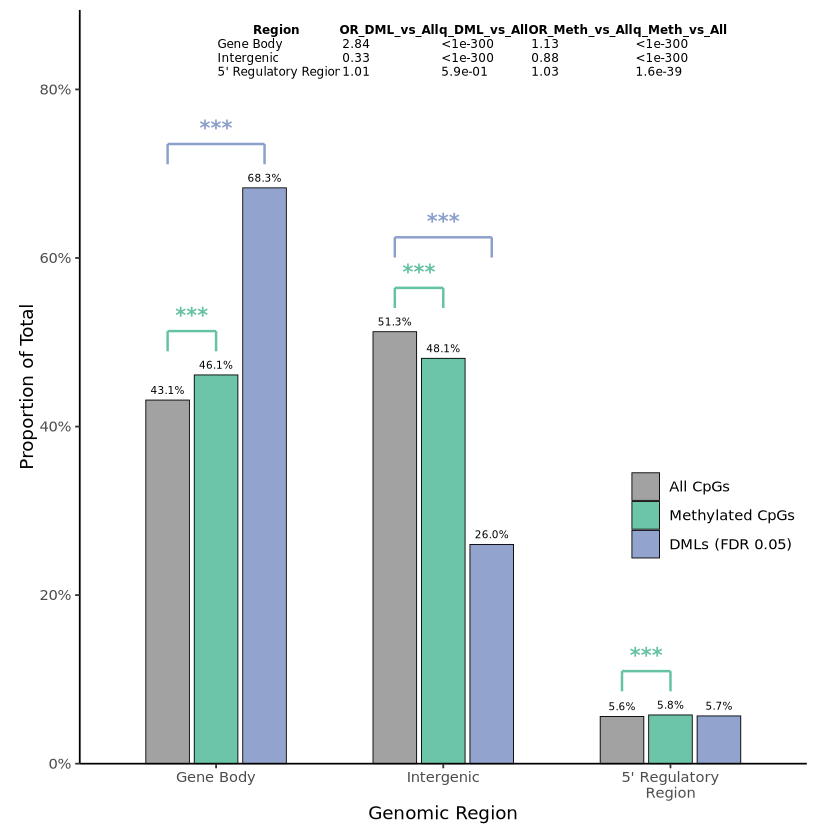

In [160]:
# =========================
# PANEL A — final module
# =========================
# Assumes these already exist: REGION_LEVELS_TC, enforce_region_order(),
# union_annot, bg_counts_all, bg_counts_meth, region_df_plot
# stars(), fmt_q() and colors: COL_ALL, COL_METH, COL_DML

# Labels & bar order (legend uses the same)
dml_label <- "DMLs (FDR 0.05)"
A_LIMITS  <- c("All CpGs","Methylated CpGs", dml_label)
A_FILL    <- c("All CpGs"=COL_ALL, "Methylated CpGs"=COL_METH, "DMLs (FDR 0.05)"=COL_DML)

# Make sure plotting df uses that order
region_df_plot <- region_df_plot %>%
  dplyr::mutate(source = factor(as.character(source), levels = A_LIMITS),
                region = enforce_region_order(region))

# ---- Enrichment tests (for symbols + table) ----
enrich_A_DML <- purrr::map_dfr(REGION_LEVELS_TC, function(reg){
  dml_in  <- sum(as.character(union_annot$region) == reg)
  dml_out <- nrow(union_annot) - dml_in
  all_in  <- as.integer(bg_counts_all[reg]); all_out <- sum(bg_counts_all) - all_in
  ft <- fisher.test(matrix(c(dml_in, dml_out, all_in, all_out), nrow = 2))
  tibble::tibble(region = reg, OR = unname(ft$estimate), p = ft$p.value)
}) %>% dplyr::mutate(q = p.adjust(p, "BH"))

enrich_A_METH <- purrr::map_dfr(REGION_LEVELS_TC, function(reg){
  meth_in <- as.integer(bg_counts_meth[reg]); meth_out <- sum(bg_counts_meth) - meth_in
  all_in  <- as.integer(bg_counts_all[reg]);  all_out  <- sum(bg_counts_all) - all_in
  ft <- fisher.test(matrix(c(meth_in, meth_out, all_in, all_out), nrow = 2))
  tibble::tibble(region = reg, OR = unname(ft$estimate), p = ft$p.value)
}) %>% dplyr::mutate(q = p.adjust(p, "BH"))

# ---- Base bars (ordered & colored) ----
pdodge <- position_dodge2(width = 0.86, preserve = "single")
pA_base <- ggplot2::ggplot(region_df_plot, aes(region, proportion, fill = source)) +
  ggplot2::geom_col(position = pdodge, width = 0.64,
                    alpha = 0.96, color = "black", linewidth = 0.25) +
  ggplot2::scale_x_discrete(labels = c("Gene Body","Intergenic","5' Regulatory\nRegion"), drop = FALSE) +
  ggplot2::scale_y_continuous(labels = scales::percent_format(accuracy = 1),
                              expand = expansion(mult = c(0, 0.20))) +
  ggplot2::scale_fill_manual(values = A_FILL, limits = A_LIMITS, drop = FALSE) +
  ggplot2::labs(x = "Genomic Region", y = "Proportion of Total") +
  ggplot2::coord_cartesian(clip = "off") +
  ggplot2::theme_classic(base_size = 11) +
  ggplot2::theme(
    legend.position      = c(0.985, 0.26),  # right side, under stats
    legend.justification = c(1, 0),
    legend.title         = element_blank(),
    legend.background    = element_rect(fill = "white"),
    plot.margin          = margin(t = 6, r = 20, b = 10, l = 12)
  )

# ---- Exact x positions from ggplot_build ----
gb <- ggplot_build(pA_base)
bars <- gb$data[[1]] %>%
  dplyr::arrange(round(x), xmin) %>%
  dplyr::mutate(
    region = rep(REGION_LEVELS_TC, each = length(A_LIMITS)),
    source = rep(A_LIMITS,            times = length(REGION_LEVELS_TC)),
    xmid   = (xmin + xmax)/2
  ) %>%
  dplyr::select(region, source, xmid)

bars_all  <- bars %>% dplyr::filter(source == "All CpGs")        %>% dplyr::rename(x_all  = xmid)
bars_meth <- bars %>% dplyr::filter(source == "Methylated CpGs") %>% dplyr::rename(x_meth = xmid)
bars_dml  <- bars %>% dplyr::filter(source == dml_label)         %>% dplyr::rename(x_dml  = xmid)

# ---------- EXACT % LABELS (centered over each bar) ----------
bar_props <- region_df_plot %>% dplyr::select(region, source, proportion)

bars_mid <- dplyr::bind_rows(
  bars_all  %>% dplyr::mutate(source = "All CpGs"),
  bars_meth %>% dplyr::mutate(source = "Methylated CpGs"),
  bars_dml  %>% dplyr::mutate(source = dml_label)
) %>%
  dplyr::left_join(bar_props, by = c("region","source")) %>%
  dplyr::mutate(
    xmid  = dplyr::coalesce(x_all, x_meth, x_dml),  # <-- unify center column
    y_lab = proportion + 0.012,
    lab   = sprintf("%.1f%%", proportion*100)
  )

pA_base <- pA_base +
  ggplot2::geom_text(
    data = bars_mid,
    aes(x = xmid, y = y_lab, label = lab),
    inherit.aes = FALSE, size = 2.2
  )
# ================== BRACKETS & ASTERISKS (non-overlapping, above % labels) ==================

# 1) Pull the % label heights per region/series (you already built bars_mid)
#    -> ylab_* maps include the small +0.012 padding you used for the % labels
ylab_map <- function(series) {
  m <- bars_mid %>%
    dplyr::filter(source == series) %>%
    dplyr::transmute(region = as.character(region), y_lab) %>%
    tibble::deframe()
  # ensure all regions exist in the map
  m[as.character(REGION_LEVELS_TC)]
}
ylab_all  <- ylab_map("All CpGs")
ylab_meth <- ylab_map("Methylated CpGs")
ylab_dml  <- ylab_map(dml_label)

# 2) Build per-region baseline heights for the two comparisons,
#    taking the MAX of the two bars' % label heights (so brackets sit above labels)
PAD_MAIN   <- 0.040   # base lift above tallest % label
PAD_TOOTH  <- 0.024   # bracket "tooth" length
SEP_EXTRA  <- 0.060   # extra lift to separate when both brackets are present

ytop_dml  <- pmax(ylab_all,  ylab_dml,  na.rm = TRUE)  + PAD_MAIN
ytop_meth <- pmax(ylab_all,  ylab_meth, na.rm = TRUE)  + PAD_MAIN
names(ytop_dml)  <- names(ylab_all)
names(ytop_meth) <- names(ylab_all)

# --- 3) Only separate when BOTH comparisons are sig AND the exact same bar wins ---

# heights by region
h_all  <- hmat$`All CpGs`
h_dml  <- hmat[[dml_label]]
h_meth <- hmat$`Methylated CpGs`
names(h_all) <- names(h_dml) <- names(h_meth) <- as.character(hmat$region)

# who actually wins each pair (use explicit labels so DML vs Meth differ)
winner_dml  <- ifelse(h_dml  >= h_all,  "DML",  "All")
winner_meth <- ifelse(h_meth >= h_all,  "Meth", "All")

# significance by region
q_dml_by_reg  <- setNames(enrich_A_DML$q,  enrich_A_DML$region)
q_meth_by_reg <- setNames(enrich_A_METH$q, enrich_A_METH$region)
both_sig <- names(h_all)[ (q_dml_by_reg[names(h_all)]  < 0.05) &
                          (q_meth_by_reg[names(h_all)] < 0.05) ]

# regions where both are sig AND the *same actual bar* is tallest
same_winner <- both_sig[ winner_dml[both_sig] == winner_meth[both_sig] ]

# start from baseline heights (already computed above your step 3)
ytop_dml  <- pmax(ylab_all,  ylab_dml,  na.rm = TRUE) + PAD_MAIN
ytop_meth <- pmax(ylab_all,  ylab_meth, na.rm = TRUE) + PAD_MAIN

# lift only when the same exact bar wins both comparisons
if (length(same_winner)) {
  # lift blue (DML) brackets; switch to ytop_meth[...] if you prefer lifting green instead
  ytop_dml[same_winner] <- ytop_dml[same_winner] + SEP_EXTRA
}

# --- 4/5) build brackets/asterisks with ytop_map = ytop_dml / ytop_meth, then draw ---
pair_dml  <- make_pair(enrich_A_DML,  "dml",  ytop_map = ytop_dml)
pair_meth <- make_pair(enrich_A_METH, "meth", ytop_map = ytop_meth)

pA_core <- pA_base
if (!is.null(pair_dml$br))  pA_core <- add_bracket(pA_core, pair_dml$br,  COL_DML)
if (!is.null(pair_meth$br)) pA_core <- add_bracket(pA_core, pair_meth$br, "#66C2A5")

if (!is.null(pair_dml$stars)) {
  pA_core <- pA_core + ggplot2::geom_text(
    data = pair_dml$stars, aes(x = x_star, y = y_star, label = lab),
    inherit.aes = FALSE, color = COL_DML, size = 4.4, fontface = "bold", vjust = 0
  )
}
if (!is.null(pair_meth$stars)) {
  pA_core <- pA_core + ggplot2::geom_text(
    data = pair_meth$stars, aes(x = x_star, y = y_star, label = lab),
    inherit.aes = FALSE, color = "#66C2A5", size = 4.4, fontface = "bold", vjust = 0
  )
}

# --- Stats box a bit farther right and slightly wider ---
pA <- cowplot::ggdraw(pA_core) +
  cowplot::draw_plot(ggplotify::as.ggplot(tbl_grob),
                     x = 0.50, y = 0.84, width = 0.12, height = 0.20)

pA
# =========================

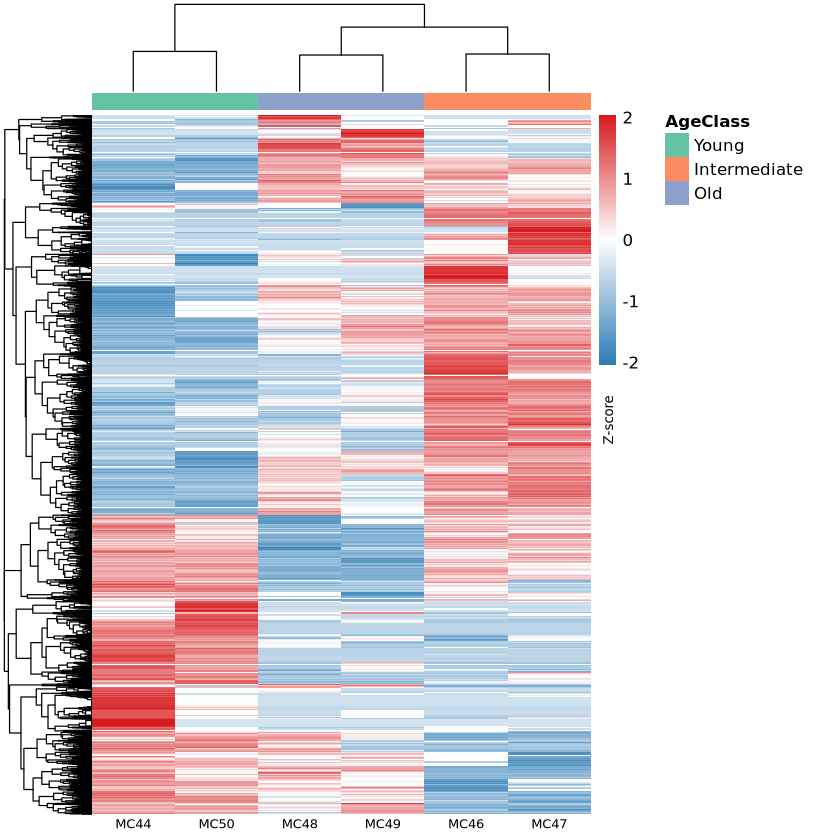

In [122]:
# ===== PANEL B =====
# Needs: design, AGE_COLORS, HEAT_COLS, HEATMAP_MAX_ROWS, sfx already defined above.

# 1) Load UNION DML methylation matrix and z-score rows
meth_mat_rds <- glue::glue("meth_matrix_dml_union_fdr{sfx}.rds")
stopifnot(file.exists(meth_mat_rds))
meth_mat <- readRDS(meth_mat_rds)                  # rows: loci; cols: samples
z_mat <- t(scale(t(meth_mat)))                     # row-wise z
z_mat[is.na(z_mat)] <- 0

# 2) Build sample annotation from `design`
ann <- data.frame(AgeClass = factor(as.character(design$group),
                                    levels = c("Young","Intermediate","Old")))
rownames(ann) <- rownames(design)

# 3) Align columns/samples present in both matrix and design
common_samples <- intersect(colnames(z_mat), rownames(ann))
z_mat <- z_mat[, common_samples, drop = FALSE]
ann   <- ann[common_samples, , drop = FALSE]

# 4) Optional row cap for speed
if (nrow(z_mat) > HEATMAP_MAX_ROWS) {
  set.seed(42)
  keep <- sample(seq_len(nrow(z_mat)), HEATMAP_MAX_ROWS)
  z_mat_hm <- z_mat[keep, , drop = FALSE]
} else {
  z_mat_hm <- z_mat
}

# 5) Symmetric color scale around 0
lim <- max(abs(range(z_mat_hm, na.rm = TRUE)))
breaks <- seq(-lim, lim, length.out = length(HEAT_COLS))

# 6) Shorten column labels (e.g., "MC##") AND keep annotation rownames in sync
short_name <- function(s) {
  m <- regmatches(s, regexpr("M\\s*\\d+", s))
  if (length(m) && m != "-1") sprintf("MC%s", gsub("\\D", "", m)) else s
}
colnames(z_mat_hm) <- vapply(colnames(z_mat_hm), short_name, character(1))
rownames(ann) <- colnames(z_mat_hm)

# 7) Age-class colors
ann_colors <- list(AgeClass = AGE_COLORS)

# 8) Render heatmap once and convert to ggplot (no extra overlays -> no duplicate B)
pB_hm <- pheatmap::pheatmap(
  z_mat_hm,
  color = HEAT_COLS, breaks = breaks,
  annotation_col = ann, annotation_colors = ann_colors,
  annotation_names_col = FALSE,
  legend = TRUE, annotation_legend = TRUE,
  show_rownames = FALSE, show_colnames = TRUE,
  fontsize_col = 7.8, angle_col = 0,
  clustering_method = "complete",
  silent = TRUE
)

# Add a “Z-score” title next to the colorbar without creating a second panel
pB <- cowplot::ggdraw(ggplotify::as.ggplot(pB_hm[[4]])) +
  cowplot::draw_label("Z-score", x = 0.724, y = 0.50, angle = 90, size = 8)

pB
# ===== END PANEL B =====

In [142]:
# ===== PANEL C =====

# rebuild panels (internal labels), show "Flat/Irreg." in title only
pC_inc  <- make_traj_panel("Increasing",     "#8DA0CB")
pC_dec  <- make_traj_panel("Decreasing",     "#66C2A5")
pC_flat <- make_traj_panel("Flat/Irregular", "#4d4d4d", max_lines_override = TRAJ_MAX_LINES_PER_PANEL_FLAT) +
           theme() +   # no change to theme, just to append dotted line below
           NULL

# add dotted mean to flat panel
pC_flat <- {
  df_flat <- build_df("Flat/Irregular", TRAJ_MAX_LINES_PER_PANEL_FLAT)$df
  mline_f <- df_flat %>% group_by(AgeGroup) %>% summarise(zmean = mean(zmean, na.rm = TRUE), .groups = "drop")
  pC_flat + geom_line(data = mline_f, aes(AgeGroup, zmean, group = 1),
                      linewidth = 1.05, color = "#4d4d4d", linetype = "dashed", inherit.aes = FALSE)
}

# tighter side margins -> more room for shared axes
# tighter margins; pull panels inward
pC_inc  <- pC_inc  + theme(plot.margin = margin(t = 10, r = 3, b = 28, l = 10))
pC_dec  <- pC_dec  + theme(plot.margin = margin(t = 10, r = 3, b = 28, l = 3))
pC_flat <- pC_flat + theme(plot.margin = margin(t = 10, r = 10, b = 28, l = 3))

trip <- cowplot::plot_grid(pC_inc, pC_dec, pC_flat, ncol = 3, rel_widths = c(1,1,1), align = "h")

# draw a bit to the right so Y label doesn't touch panel 1; X label placed to match D
pC <- cowplot::ggdraw() +
  cowplot::draw_plot(trip, x = 0.035, y = 0, width = 0.94, height = 1) +
  cowplot::draw_label("Z-score",      x = 0.020, y = 0.50, angle = 90, size = 11) +
  cowplot::draw_label("Genomic Region", x = 0.52,  y = 0.040,        size = 11)

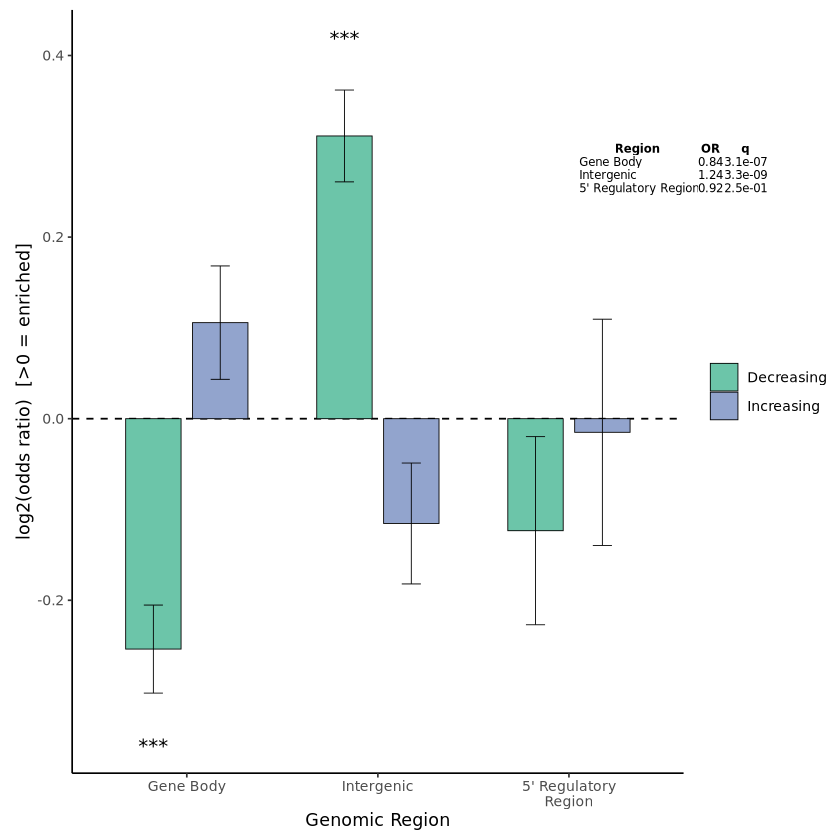

In [171]:
# ===================== PANEL D — Enrichment by region (Inc/Dec vs all DMLs) =====================

suppressMessages({
  library(dplyr); library(tidyr); library(tibble); library(ggplot2)
  library(gridExtra); library(cowplot); library(glue)
})

# Pastel fills (older figure look)
D_COLORS <- c(Decreasing = "#66C2A5", Increasing = "#8DA0CB")

# --- Controls ---
SE_MULT <- 1.0   # 1.0 = ±1 SE (narrow); 1.96 ~ 95% CI if you want wider bands
TREND_TOL <- 0.15

# ---- Input: UNION DML matrix -> trend calls per locus ----
sfx <- sprintf("%02d", as.integer(100 * FDR_TO_ANNOTATE))
meth_mat_rds <- glue("meth_matrix_dml_union_fdr{sfx}.rds")
stopifnot(file.exists(meth_mat_rds))

meth_mat <- readRDS(meth_mat_rds)                 # rows = loci "chr:pos", cols = samples
z_mat    <- t(scale(t(meth_mat))); z_mat[is.na(z_mat)] <- 0

# Align columns to design (AgeClass order)
age_levels <- c("Young","Intermediate","Old")
ann <- data.frame(AgeClass = factor(as.character(design$group), levels = age_levels),
                  row.names = rownames(design))
common <- intersect(colnames(z_mat), rownames(ann))
z_mat  <- z_mat[, common, drop = FALSE]
ann    <- ann[common, , drop = FALSE]
age_vec <- factor(as.character(ann$AgeClass), levels = age_levels)

# Per-locus means by age, then classify trend
means_by_age <- sapply(age_levels, function(a){
  cols <- which(age_vec == a)
  if (length(cols)) rowMeans(z_mat[, cols, drop = FALSE], na.rm = TRUE) else rep(NA_real_, nrow(z_mat))
})
colnames(means_by_age) <- age_levels

trend_class <- function(v, tol = TREND_TOL){
  if (any(is.na(v))) return("Flat/Irregular")
  dy1 <- v[2]-v[1]; dy2 <- v[3]-v[2]
  if (dy1 >  tol && dy2 >  tol) return("Increasing")
  if (dy1 < -tol && dy2 < -tol) return("Decreasing")
  "Flat/Irregular"
}
trend_vec <- apply(means_by_age, 1, trend_class)
trend_df  <- tibble(locus = rownames(z_mat),
                    trend = factor(trend_vec, levels = c("Increasing","Decreasing","Flat/Irregular")))

# Map loci to regions and keep only UNION DMLs that have region labels
union_annot <- union_annot %>%
  mutate(locus = paste0(chr, ":", pos),
         region = enforce_region_order(region))

mono_with_region <- trend_df %>%
  inner_join(union_annot %>% select(locus, region), by = "locus") %>%
  tidyr::drop_na(region)

# Background (all UNION DMLs) region counts
union_counts <- table(enforce_region_order(union_annot$region))

# ---- Enrichment per region: each trend vs all UNION DMLs ----
enrich_region <- function(fg_regions, bg_counts){
  tibble(region = REGION_LEVELS_TC) %>%
    rowwise() %>%
    mutate(
      a = sum(fg_regions == region, na.rm = TRUE),
      b = length(fg_regions) - a,
      c = as.integer(bg_counts[region]),
      d = sum(bg_counts) - c,
      # continuity correction if any cell is 0
      cc  = if (min(a,b,c,d) == 0L) 0.5 else 0,
      a2  = a + cc,
      b2  = b + cc,
      c2  = c + cc,
      d2  = d + cc,
      logOR = log((a2*d2) / (b2*c2)),
      se    = sqrt(1/a2 + 1/b2 + 1/c2 + 1/d2),
      OR    = exp(logOR),
      lo    = exp(logOR - SE_MULT*se),
      hi    = exp(logOR + SE_MULT*se),
      p     = fisher.test(matrix(c(a, b, c, d), nrow = 2))$p.value
    ) %>%
    ungroup() %>% select(region, OR, lo, hi, p)
}

res_inc <- enrich_region(mono_with_region %>% filter(trend=="Increasing") %>% pull(region),
                         union_counts) %>% mutate(trend = "Increasing")
res_dec <- enrich_region(mono_with_region %>% filter(trend=="Decreasing") %>% pull(region),
                         union_counts) %>% mutate(trend = "Decreasing")

res_D <- bind_rows(res_inc, res_dec) %>%
  group_by(trend) %>% mutate(q = p.adjust(p, "BH")) %>% ungroup() %>%
  mutate(
    region = enforce_region_order(region),
    trend  = factor(trend, levels = c("Decreasing","Increasing")),
    log2OR = log2(OR), lo_l2 = log2(lo), hi_l2 = log2(hi),
    star   = case_when(q < 1e-3 ~ "***", q < 1e-2 ~ "**", q < 5e-2 ~ "*", TRUE ~ "")
  )

# Star positions: just beyond the interval tip (separate by trend with dodge)
STAR_PAD <- 0.05
res_D <- res_D %>%
  mutate(star_y = if_else(log2OR >= 0, hi_l2 + STAR_PAD, lo_l2 - STAR_PAD))

# ---- Plot (pastel fills, narrow SE bands) ----
pd <- position_dodge(width = 0.70)

pD_core <- ggplot(res_D, aes(x = region, y = log2OR, fill = trend)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_col(position = pd, width = 0.58, color = "black", linewidth = 0.25, alpha = 0.96) +
  geom_errorbar(aes(ymin = lo_l2, ymax = hi_l2), position = pd, width = 0.20, linewidth = 0.25) +
  geom_text(aes(y = star_y, label = star), position = pd,
            vjust = ifelse(res_D$log2OR >= 0, 0, 1), size = 4.2, show.legend = FALSE) +
  scale_fill_manual(values = D_COLORS, guide = guide_legend(title = NULL)) +
  scale_x_discrete(labels = c("Gene Body","Intergenic","5' Regulatory\nRegion")) +
  labs(x = "Genomic Region", y = "log2(odds ratio)  [>0 = enriched]") +
  theme_classic(base_size = 10.5) +
  theme(legend.position = "right",
        plot.margin = margin(t = 6, r = 10, b = 6, l = 10))

# ---- Compact stats inset (show OR + q; here: Decreasing only like before) ----
fmt_q <- function(x) ifelse(x == 0, "<1e-300", formatC(x, format = "e", digits = 1))
tblD <- res_D %>%
  filter(trend == "Decreasing") %>%
  transmute(Region = region, OR = round(OR, 2), q = fmt_q(q))

tblD_grob <- gridExtra::tableGrob(
  tblD, rows = NULL,
  theme = gridExtra::ttheme_minimal(
    base_size = 7,
    core    = list(fg_params = list(hjust = 0, x = 0.02),
                   padding   = grid::unit(c(0.5, 2.5), "pt")),
    colhead = list(fg_params = list(fontface = "bold"),
                   padding   = grid::unit(c(0.5, 2.5), "pt"))
  )
)

pD <- cowplot::ggdraw(pD_core) +
  cowplot::draw_plot(ggplotify::as.ggplot(tblD_grob),
                     x = 0.62, y = 0.63, width = 0.36, height = 0.34)

# pD is the final Panel D object
pD
# ================================================================================================

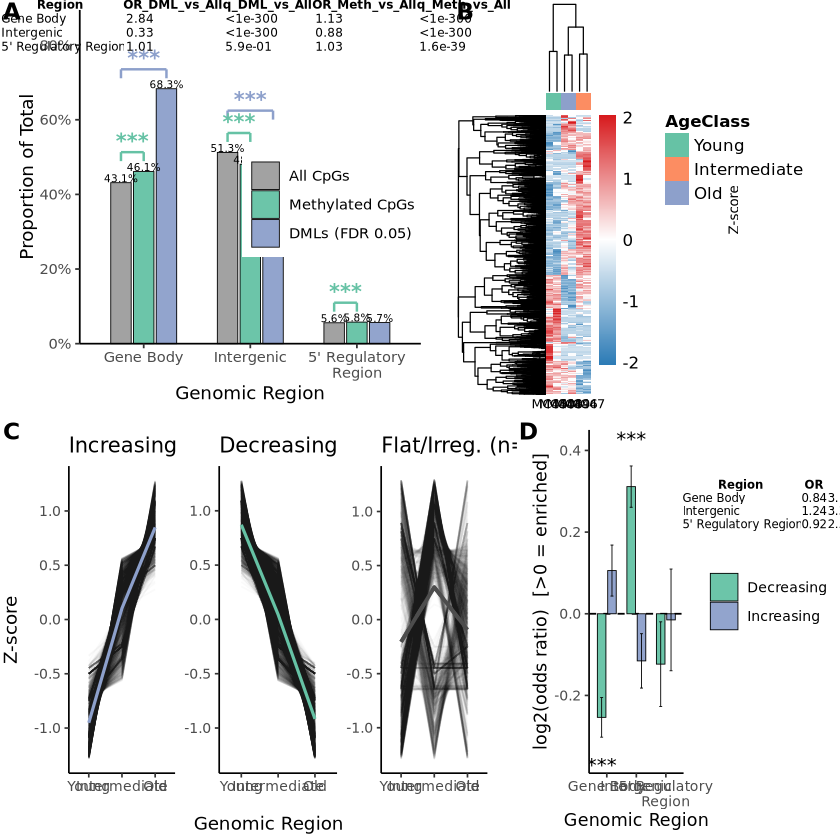

In [172]:
# ===== FULL PANEL SET FIG

# Helper to tag panels cleanly
tag_panel <- function(p, tag) {
  cowplot::ggdraw() +
    cowplot::draw_plot(p) +
    cowplot::draw_label(tag, x = 0.006, y = 0.994, hjust = 0, vjust = 1,
                        fontface = "bold", size = 14)
}

top_row    <- cowplot::plot_grid(tag_panel(pA, "A"), tag_panel(pB, "B"),
                                 ncol = 2, rel_widths = c(1.20, 1.02))
bottom_row <- cowplot::plot_grid(tag_panel(pC, "C"), tag_panel(pD, "D"),
                                 ncol = 2, rel_widths = c(1.6, 1))

fig_all <- cowplot::plot_grid(top_row, bottom_row, ncol = 1, rel_heights = c(1, 1))
print(fig_all)
ggsave("Fig4.pdf", fig_all, width = 10.5, height = 8.0, units = "in")
ggsave("Fig4.png", fig_all, width = 10.5, height = 8.0, units = "in", dpi = 300)